<a href="https://colab.research.google.com/github/sagarwal10/kaggle-learn/blob/master/CS67_FINAL_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CS67 Final Project  - Shalabh and Alex**

---



## Abstract:
The world is filled with information and the rate at which it's produced only continues to grow. In this environment, a key challenge is learning to reliably distinguish between signal and noise to enhance decision making and understand identify trends. Companies, brands, and entertainers make product and service decisions on the basis of customer/audience feedback, but how does one do so effectively when the most direct channel for feedback - social media - is increasingly dominated by spam? To address this growing challenge, we will deploy several methods to identify spam using a public set of comments collected for spam research and determine which method most reliably identifies YouTube spam and leaves us with a data set of true commentary that can be used to conduct sentiment analysis from real fans and detractors. 

##Outline:

**1. Introduction**:

We are seeking to distinguish spam from genuine comments left on the videos of prominent entertainers. The source we are using, provided in Kaggle, includes five datasets composed by 1,956 real messages extracted from five videos that were among the 10 most viewed on the collection period. We seek to effectively identify spam among the comments.  

**2. Exploratory data analysis:**

Challenges we anticipate:
-Abbreviations, capitalization, incorrect spelling, slang, and poor grammar 
-Habits of spam posters that may unknowingly be pre-processed out of the set (e.g., URLs in comments)  

**3. Baseline Model**

The methodology we plan to employ is outlined below. We will first attempt to run the methodology without pre-processing, to establish a baseline of results to compare against.   
Using the text classification methodology outlined in Week 5 of the NLP course, we intend to examine the kaggle YouTube comments data set in order to identify and quantify spam and potentially to use the remaining non-spam comments to conduct a sentiment analysis. Methods include: 
*   Utilizing bag of words followed by TF-IDF as a subsequent model improvement to ultimately compare 4 different classification models (LinearSVC, LogisticRegression, RandomForestClassifier, and MultinomialNB)
*   Time permitting, we would also like to utilize Latent Sentiment Analysis to see if we could find a vector for spam and  a vector that differentiates the 5 different artists

**4. Model Improvement**

Following the creation of the baseline to compare against, we will then pre-process the dataset using techniques including lemmatization, tokenization, stop-word removal, unusual character removal, URL tokenization replacement, lowercasing, expand contractions, white space removal. Following the pre-processing we will again deploy the 4 classification models and examine the improvement.

The models will be broken out into training and test sets (80-20 distribution). Using K-Fold cross-validation, we will assess the accuracy of our models and compare which one or multiple ones are most effective for this data set.

**5. Final results**: 

We will provide a presentation featuring a  thorough discussion of final quantitative metrics and qualitative visualizations. We will also discuss some of the biggest intermediate advancements that helped us improve the final model and share any insights we have derived from our results. 
   

### EDA


The dataset contains of youtube comments from 5 different artists. We will collect them into a single Pandas Dataframe and examine the contents.


In [49]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import collections

dfYTSpam=pd.read_csv("https://sagarwal10-test.s3-us-west-2.amazonaws.com/kaggle_youtube_spam_dataset.csv", delimiter=",")

# since we were appending multiple CSV's we want to reindex the Data
# https://stackoverflow.com/questions/35528119/pandas-recalculate-index-after-a-concatenation
# dfYTSpam.reset_index(drop=True, inplace=True)
nRow, nCol = dfYTSpam.shape
print(f'There are {nRow} rows and {nCol} columns')
print(dfYTSpam.iloc[1586]['content'])

There are 1956 rows and 5 columns
Nice song﻿


There are 1956 entries of data with 5 columns. For our purposes the two most meaningful columns are content and class. The content denotes the actual textual comment made by the user. The class is a label - TRUE if the comment is SPAM and FALSE if its a valid comment (i.e. ham). In our example above we see that entry 7 is a valid comment whereas the others are simply people pointing to other websites and thus spam.


Amount of SPAM vs HAM

In [50]:

spam_class=dfYTSpam['class'] == True
ham_class=dfYTSpam['class'] == False
print(" Number of SPAM comments: " + str(len(dfYTSpam[spam_class])))
print(" Number of HAM comments: " + str(len(dfYTSpam[ham_class])))


 Number of SPAM comments: 1005
 Number of HAM comments: 951


We see that the dataset is fairly evenly divided at 51.40% Spam. This means we should have decent training

Now lets see if we should considers authors as part of our dataset. This will only matter if certain authors are more likely to be habitual spammers.


In [51]:
from collections import Counter

Counter(dfYTSpam[spam_class].duplicated(subset='author'))

Counter({False: 871, True: 134})

This tells us that roughly 14% of the spam posts have been authored at least twice by the same person. We might consider using this in our model as an improvement. In practise a social media company would most likely use this. 
Next we will try to consider how many of the spam emails have a URL of a website included in them.


In [52]:
import re
# Regular expression from https://www.geeksforgeeks.org/python-check-url-string/
regex_url = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
print("Number of SPAM comments containing URLs = " + str(len(dfYTSpam[spam_class][dfYTSpam[spam_class]['content'].str.contains(regex_url, regex=True)])))
print("Number of HAM comments containing URLS = " + str(len(dfYTSpam[ham_class][dfYTSpam[ham_class]['content'].str.contains(regex_url, regex=True)])))




Number of SPAM comments containing URLs = 201
Number of HAM comments containing URLS = 11


/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [53]:
regex_url = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
dfYTSpam[spam_class][dfYTSpam[spam_class]['content'].str.contains(regex_url, regex=True)]
# dfYTSpam.iloc[1586]['content']
re.sub(regex_url, "WebURL", dfYTSpam.iloc[12]['content'], flags=re.MULTILINE)

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


'WebURL'

We see that 20% of SPAM contains URL vs only a percent in non spam class. So this might be a good optimization to remove URLs and replace them with a word like "URL" since its unlikely that the tokenizer will be able to produce anything useful token-wis from a URL.


### Initial Model Train & Test


We are going to split the data into training and test data by a ration of 80-20 percent.


In [54]:
from sklearn.model_selection import train_test_split
trainComments, testComments, trainLabel, testLabel = train_test_split( dfYTSpam['content'], dfYTSpam['class'], test_size=.2, random_state=0)

In [55]:
print("Number of samples of Training Data: "+ str(len(trainComments)))
print("Number of samples of Test Data: " + str(len(testComments)))

Number of samples of Training Data: 1564
Number of samples of Test Data: 392


We see that indeed the split is 80-20. Next we create a bag of words model using the CountVectorizer. We don't specify the stopwords parameter as we want to get an idea of the performance without doing any preprocessing.




In [56]:
from sklearn.feature_extraction.text import CountVectorizer
CntVec = CountVectorizer(binary=False, min_df=0.0, max_df=1.0)   
trainingVec = CntVec.fit_transform(trainComments)     
testingVec = CntVec.transform(testComments)   
testingVec.shape


(392, 3812)

We see that we have transformed the data into a bag of words of dictionary size 3812.

In [57]:
print(CntVec.get_feature_names()[0:10])
print(CntVec.get_feature_names()[3800:3811])


['00', '000', '002', '018', '02', '034', '04', '047000', '05', '053012']
['zonepa', 'zxlightsoutxz', 'οh', 'الإعلانات', 'لل', '강남스타일', 'ｃｏｍ', 'ｅｂａｙ', 'ｈｔｔｐ', 'ｓｈｏｅｃｏｌｌｅｃｔｏｒ314', 'ｕｓｒ']


We notice that as a result of not preprocessing we have numbers and foreign characters that should definitely be removed. Next lets look at the distribution of length of words.

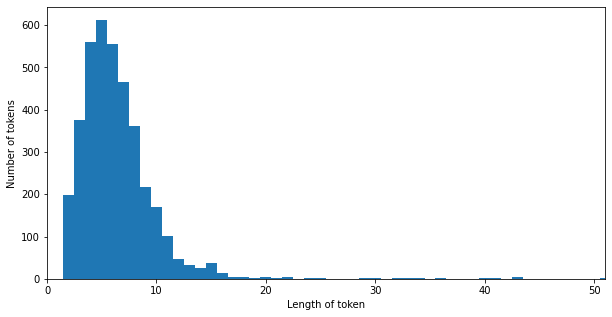

In [58]:
import numpy as np
import matplotlib.pyplot as plt 
 
cnt=Counter()
for word in CntVec.get_feature_names():
  cnt[len(word)] += 1
fig = plt.figure(figsize = (10, 5))
plt.bar(cnt.keys(), cnt.values(), width = 1)
plt.xlim(0, 51)
plt.xlabel('Length of token')
plt.ylabel('Number of tokens')
plt.show()


In [59]:
for word in CntVec.get_feature_names():
  if len(word) > 30:
    print(word)

1fhenqx1twqm153v2ptayiejnealahzvem
2flist_of_most_viewed_youtube_videos
5bgkg2iwphzohwaeuesrwnegqg_labco7rw9wfx8hao
89iyec7nrwp5nytno5u7amhvmflutggl
90000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
dislikesssssssssssssssssssssssssssssssss
i9tixe8cnkcosoqkemgjlu5uwv6nsxso
lneadw26bfst76vhkjl8pxaey6vmnlvmriudtsfk6vy
lneadw26bftvzqt6juehasiefrjg1exi_dvqdnqvpho
lneadw26bfunoarag71awgu6tjo6azdkfiun_tz1_hy
lneadw26bfvkahxpkenm25fywkyxthsupri6juqsznu
plzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
soooooooooooooooooooooooooooooooooooooooo
soooooooooooooooooooooooooooooooooooooooooooooooooo
wowwwwwwwwwwwwwwwwwwwwwwwwwwwwww


In [61]:
filter=dfYTSpam['content'].str.find('soooooooooooooooooooooooooooooooooooooooo') > 0
dfYTSpam[filter]

,comment_id,author,date,content,class
695,z12sjp3zgtqnvlysj23zuxxaolrvd1oj504,Kacy Cluley,2015-06-05T18:59:52,This song means so much to me thank you soooo...,False
807,z120t12qtr23etulr23rvzbyfyj1yfons,Mayen Dabuol,2015-05-22T01:59:18.387,Love this sooooooooooooooooooooooooooooooooooo...,False


We see from the bar graph that we have some really large words that are nonsensical and also a lot of repeated characters for regular English words to provide emphasis. Preprocessing can be used here as well.


We will start off by using a Bayes model to train and then come up with train and test accuracy scores


In [62]:
import sklearn
from sklearn.naive_bayes import MultinomialNB
model=MultinomialNB()
model.fit(trainingVec, trainLabel)
arrCVS = sklearn.model_selection.cross_val_score(model, trainingVec, trainLabel, cv=5);

print("Training data score/accuracy is "+str(round(model.score(trainingVec, trainLabel), 4)))
print("Testing data score/accuracy is "+str(round(model.score(testingVec, testLabel), 4)))
print("5 fold cross validation accuracy is "+str(round(np.mean(arrCVS), 4)))


Training data score/accuracy is 0.9642
Testing data score/accuracy is 0.9158
5 fold cross validation accuracy is 0.9188


We notice that even without preprocessing we get a fairly good accuracy of 92% with both the testing and the 5 fold cross validation test. Lets see if we can improve that with pre processing.


### Preprocessing and retrain model 




We will now attempt to preprocess the comments to remove special characters, abbreviations, expand contractions, remove stopwords and of course repetitions of characters and try to see how that affects our NB model and its accuracy. All preprocessing code here comes from CS67 Week 5 colab with modifications.


In [126]:
#########################################################
# Source: Text Analytics with Python by Dipanjan Sarkar
#########################################################
!pip -q install contractions > tmp.log
import nltk, spacy, unicodedata, re, collections
from contractions import contractions_dict
from nltk.corpus import wordnet
from nltk.tokenize.toktok import ToktokTokenizer
from bs4 import BeautifulSoup
#from textblob import Word
nltk.download('wordnet')
nltk.download('punkt')
nltk.download(['stopwords'], quiet=True)
LosStopWords = nltk.corpus.stopwords.words('english')
nlp = spacy.load('en_core_web_sm', parse=True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
# nlp_vec = spacy.load('en_vectors_web_lg', parse=True, tag=True, entity=True)

def RemHTMLTags(txt):
    soup = BeautifulSoup(txt, "html.parser")
    if bool(soup.find()): 
      # [s.extract() for s in soup(['iframe', 'script'])]
      return re.sub(r'[\r|\n|\r\n]+', '\n', soup.get_text())
    return txt

def remove_repeated_characters(tokens):
    repeat_pattern = re.compile(r'(\w*)(\w)\2(\w*)')
    match_substitution = r'\1\2\3'
    def replace(old_word):
        if wordnet.synsets(old_word):
            return old_word
        new_word = repeat_pattern.sub(match_substitution, old_word)
        return replace(new_word) if new_word != old_word else new_word
            
    correct_tokens = [replace(word) for word in tokens]
    return correct_tokens

def RemDupChar(tokens):
    repeat_pattern = re.compile(r'(\w*)(\w)\2(\w*)')
    def replace(old_word):
        if wordnet.synsets(old_word): return old_word
        new_word = repeat_pattern.sub(r'\1\2\3', old_word)
        return replace(new_word) if new_word != old_word else new_word
    return ''.join([replace(word) for word in tokens])

def expand_contractions(text, contraction_mapping=contractions_dict):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        if first_char == None:
          print(contraction)
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())
        if expanded_contraction == None:
          # print(match)
          # print(contraction_mapping.get(match))
          # print(contraction_mapping.get(match.lower()))
          # print("Expanded is false")           
          expanded_contraction=match           
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text
def ExpContractions(txt, cmap=contractions_dict):
    cpat = re.compile('({})'.format('|'.join(cmap.keys())), flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        return contraction.group(0)[0]+(cmap.get(match) if cmap.get(match) else cmap.get(match.lower()))[1:]
    return re.sub("'", "", cpat.sub(expand_match, txt))

def Stem(txt): return ' '.join([nltk.porter.PorterStemmer().stem(word) for word in txt.split()])
def lemmatize_text(txt): return ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in nlp(txt)])
def RemAccChar(txt): return unicodedata.normalize('NFKD', txt).encode('ascii', 'ignore').decode('utf-8', 'ignore')
def RemSpecChar(txt, remove_digits=False): return re.sub(r'[^a-zA-Z0-9\s]|\[|\]' if not remove_digits else r'[^a-zA-Z\s]|\[|\]', '', txt)
def ReplaceURL(txt):      #Replace actual URLs with the string likelyspamurl
    return(re.sub(regex_url, "likelyspamurl", txt, flags=re.MULTILINE))
def RemStopwords(txt, lower=False, stopwords=LosStopWords):
    tokens = [token.strip() for token in tokenizer.tokenize(txt)]
    return ' '.join([t for t in tokens if (t if lower else t.lower()) not in stopwords])

def normalize_corpus(corpus, repURL=False, remDup=False, remHTML=False, expContr=False, remAccChar=False, lower=False, stem=False, 
                     lemma=False, remSpecChar=False, remDig=False, remStop=False, stopwords=LosStopWords):
    normalized_corpus = []
    # just to keep negation if any in bi-grams
    if 'no' in stopwords: stopwords.remove('no')
    if 'not' in stopwords: stopwords.remove('not')
    for doc in corpus:   # normalize each document in the corpus
        if remHTML: doc = RemHTMLTags(doc) # strip HTML
        doc = doc.translate(doc.maketrans("\n\t\r", "   ")) # remove extra newlines
        if repURL: doc=ReplaceURL(doc)
        if remAccChar: doc = RemAccChar(doc) # remove accented characters
        if expContr: doc = expand_contractions(doc) # expand contractions
        if remDup: 
            correct_tokens = remove_repeated_characters(nltk.word_tokenize(doc))
            # ' '.join(correct_tokens)
            # correct_tokens = RemDupChar(nltk.word_tokenize(doc))
            doc=' '.join(correct_tokens)
        if lemma: doc = lemmatize_text(doc)  # lemmatize text        
        if stem and not lemma: doc = Stem(doc) # stem text
        
        if remSpecChar: # remove special characters and\or digits    
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = RemSpecChar(doc, remove_digits=remDig)  

        doc = re.sub(' +', ' ', doc) # remove extra whitespace
        if lower: doc = doc.lower() # lowercase the text    
        # remove stopwords
        if remStop: doc = RemStopwords(doc, lower=lower, stopwords=LosStopWords)
        doc = re.sub(' +', ' ', doc).strip() # remove extra whitespace
        normalized_corpus.append(doc)
    return normalized_corpus






[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [102]:
def preprocess_corpus_train_model_and_score(cleaned_content_colname, **kwargs):
   dfYTSpam[cleaned_content_colname] = normalize_corpus(corpus=dfYTSpam.content, **kwargs)
   trainComments, testComments, trainLabel, testLabel = train_test_split( dfYTSpam[cleaned_content_colname], dfYTSpam['class'], test_size=.2, random_state=0)
   CntVec = CountVectorizer(binary=False, min_df=0.0, max_df=1.0)   
   trainingVec = CntVec.fit_transform(trainComments)     
   testingVec = CntVec.transform(testComments)   
   testingVec.shape
   model=MultinomialNB()
   model.fit(trainingVec, trainLabel)
   arrCVS = sklearn.model_selection.cross_val_score(model, trainingVec, trainLabel, cv=5)
   print("Accuracies - Training: "+str(round(model.score(trainingVec, trainLabel), 4))  \
         + "\tTesting: "+str(round(model.score(testingVec, testLabel),4)) + \
         "\t\t5-fold KCV: "+str(round(np.mean(arrCVS), 4)) + \
         "\tNum features: "+str(len(CntVec.get_feature_names())))

The code above will preprocess the comments, train a NB model and then compute accuracy scores. It takes in keywords for different preprocessing options.
We first call this new function with no options for preprocessing and we see that indeed the scores match exactly the numbers we got earlier also with no preprocessing

In [127]:
preprocess_corpus_train_model_and_score('newcontent')

Accuracies - Training: 0.9642	Testing: 0.9158		5-fold KCV: 0.9188	Num features: 3812


Next we will try our hypothesis to replace actual URLS in the comments with a word token (in this case 'likelyspamurl') to see if that helps the model since its assumed actual url's are unlikely to be of use


In [130]:
preprocess_corpus_train_model_and_score('newcontent', repURL=True)

Accuracies - Training: 0.9591	Testing: 0.9031		5-fold KCV: 0.9124	Num features: 3319


We notice that replacing actual URLs with a single known keyword reduced the number of CountVectizer feature names from 3812 to 3319 - a reduction of 13%. However we see that our scores SURPRISINGLY went down. Its possible that the different URLs help our model detect spam better so we will no longer replace URLs.
Next we will  test regular preprocessing features one by one adding them and seeing if the scores improve until we find the most optimal combination.



In [125]:
preprocess_corpus_train_model_and_score('newcontent', remDup=True)

Accuracies - Training: 0.9636	Testing: 0.9184		5-fold KCV: 0.9207	Num features: 3769


In [111]:
preprocess_corpus_train_model_and_score('newcontent', remDup=True, expContr=True)

Accuracies - Training: 0.9642	Testing: 0.9184		5-fold KCV: 0.9201	Num features: 3766


In [112]:
preprocess_corpus_train_model_and_score('newcontent', remDup=True, expContr=True, remAccChar=True)

Accuracies - Training: 0.9655	Testing: 0.926		5-fold KCV: 0.9214	Num features: 3743


In [115]:
preprocess_corpus_train_model_and_score('newcontent', remDup=True, expContr=True, remAccChar=True, lower=True, stem=True)

Accuracies - Training: 0.9591	Testing: 0.9286		5-fold KCV: 0.922	Num features: 3335


In [122]:
preprocess_corpus_train_model_and_score('newcontent', repURL=True, remDup=True, expContr=True, remAccChar=True, lower=True, stem=True)

Accuracies - Training: 0.9591	Testing: 0.9209		5-fold KCV: 0.9182	Num features: 2827


In [118]:
preprocess_corpus_train_model_and_score('newcontent', remDup=True, expContr=True, remAccChar=True, lower=True, stem=True, remSpecChar=True)

Accuracies - Training: 0.9578	Testing: 0.9235		5-fold KCV: 0.9214	Num features: 3202


In [120]:
preprocess_corpus_train_model_and_score('newcontent', remDup=True, expContr=True, remAccChar=True, lower=True, stem=True, remSpecChar=True, remDig=True)

Accuracies - Training: 0.954	Testing: 0.9184		5-fold KCV: 0.9194	Num features: 2977


In [121]:
preprocess_corpus_train_model_and_score('newcontent', remDup=True, expContr=True, remAccChar=True, lower=True, stem=True, remSpecChar=True, remDig=True, remStop=True)

Accuracies - Training: 0.9578	Testing: 0.9031		5-fold KCV: 0.9041	Num features: 2875
